### Wall of Imports

In [591]:
# 🔹 Standard Library Imports
import os
import getpass
import json
import shutil
import tarfile
import subprocess
import fnmatch
import functools
import operator
import xml.etree.ElementTree as ET
from ftplib import FTP
from typing import Any, Callable, List, Optional, TypedDict, Union

# 🔹 Third-Party Libraries
import requests
import pandas as pd  # Standard alias for pandas
from bs4 import BeautifulSoup
import pprint  # Useful for structured printing

# 🔹 LangChain Core Components
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.llms import OpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool

# 🔹 LangChain Embeddings & Models
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings  # Removed duplicate
from langchain_openai.chat_models import ChatOpenAI  # Removed duplicate

# 🔹 LangChain Vector Stores & Document Loaders
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_community.document_loaders import JSONLoader
from langchain_text_splitters import RecursiveJsonSplitter

# 🔹 LangChain Tools & Search Utilities
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools import TavilySearchResults

# 🔹 LangGraph (For Workflow Orchestration)
from langgraph.graph import END, StateGraph

### Enter API Keys

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["QDRANT_API_KEY"] = getpass.getpass("Qdrant API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

### Load Embeddings

In [3]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Connect to Qdrant Vector Store Collections

In [186]:
qdrant_url = "https://e788c0ea-f5df-4d96-85ac-350da677aadf.us-west-2-0.aws.cloud.qdrant.io"

# Opportunities
opportunities_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="opportunities",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

# Projects
projects_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="projects",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

# Opportunities Summary
opportunities_summary_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="opportunities_summary",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

### Create Retrievers

In [233]:
opportunities_retriever = opportunities_qdrant.as_retriever(search_kwargs={"k": 30})
projects_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 10})
opportunities_summary_retriever = opportunities_summary_qdrant.as_retriever(search_kwargs={"k": 10})
projects_summary_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 10})

### Create Prompt Templates

In [214]:
opportunities_rag_prompt_template = """\
Use only the provided context to answer the user's question about funding opportunities. If an opportunity id or title is provided, use only the context for that opportunity. Include the opportunity id, name, award amount (from the award information section), award project period (from the award information section), and a link to the opportunity id announcement in every response. Generate the link by adding the opportunity id + .html on the end of https://grants.nih.gov/grants/guide/pa-files/ 

You must include the project complexity and the required budget form in every response to a question about project complexity or budgets.

Calculate the project complexity as follows:
1) Regulatory: (High/Medium/Low) - Rank proportionately to the number of regulations required. Provide examples supporting the score.
2) Data Collection and Management: (High/Medium/Low) - Rank proportionately to number of data elements needed (per participating site), data complexity, data sensitivity, and data collection frequency. Rank higher for more participating sites. Provide examples supporting the score.
3) Statistical Analysis and Manuscript Development: (High/Medium/Low) - Estimate the level of statistical analysis involved. Rank non-standard processes higher than standard ones. Provide examples supporting the score.
4) Information Technology: (High/Medium/Low) - Rank proportionately to IT monitoring and maintenance, software licenses and subscriptions. Rank routine services lower than non-standard services. Provide examples supporting the score.
5) Operational: (High/Medium/Low) - Rank proportionately to project administration effort required and increased site onboarding, coordination and training. Provide examples supporting the score.
6) Financial: (High/Medium/Low) - Rank proportionately to budget management complexity. Provide examples supporting the score.
        
Using only the guidance provided, determine the required budget form as follows:
1) If the application proposes the use of human fetal tissue from elective abortions, use the detailed form (R&R Budget Form).
2) Else if the direct costs (minus any consortium/subcontract F&A costs) equal more than $250,000 per year, use the detailed form (R&R Budget Form).
3) Else if the opportunity is not a research grant or cooperative agreement, use the detailed form (R&R Budget Form).
4) Else if the applicant is not based in the United States, use the detailed form (R&R Budget Form).
5) Else use the modular form (PHS 398 Modular Budget Form).

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

opportunities_rag_prompt = ChatPromptTemplate.from_template(opportunities_rag_prompt_template)

In [7]:
projects_rag_prompt_template = """\
Use only the provided context to answer the user's question. If a specific project is named, use only the context for that project. Include the name of the projects in your response, and provide a link to the project details.

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

projects_rag_prompt = ChatPromptTemplate.from_template(projects_rag_prompt_template)

In [8]:
opportunities_summary_prompt_template = """\
Using only the following summarized opportunities:

    {context}

Extract the most important points and organize them into a structured table format with columns: 
"Document Number", "Title", "Activity Code", "Release Date", "Expiration Date", "URL". 
Sort the table from newest release date to oldest release date and return the table in a structured format without additional explanations.

Provide a link to the remaining funding opportunities on the NIH website here: https://grants.nih.gov/funding/nih-guide-for-grants-and-contracts
"""

opportunities_summary_prompt = ChatPromptTemplate.from_template(opportunities_summary_prompt_template)

In [9]:
projects_summary_prompt_template = """\
Using only the following summarized projects:

    {context}

Extract the most important points and organize them into a structured table format with columns: 
"Project Number", "Project Title", "Principal Investigator(s)", "Activity Code", "Award Amount", "Project Start Date", "Project End Date", "Project Detail URL". 
Sort the table from newest project start date to oldest project start date and return the table in a structured format without additional explanations.

Provide a link to the remaining projects on the NIH website here: https://reporter.nih.gov/
"""

projects_summary_prompt = ChatPromptTemplate.from_template(projects_summary_prompt_template)

### Instantiate RAG LLM

In [147]:
rag_llm = ChatOpenAI(model="gpt-4o-mini", tags=["rag_llm"])

### Create Summarizers

In [223]:
summarizer_llm = ChatOpenAI(model_name="gpt-4", tags=["summarizer_llm"])

summarizer_chain = load_summarize_chain(summarizer_llm, chain_type="map_reduce")

opportunities_summary_chain = (
    {"context": itemgetter("question") | opportunities_summary_retriever | summarizer_chain}  # Summarize retrieved docs
    | opportunities_summary_prompt  # Pass summarized context to the final prompt
    | rag_llm  # Process final output
    | StrOutputParser()  # Convert to a string output
)

projects_summary_chain = (
    {"context": itemgetter("question") | projects_summary_retriever | summarizer_chain}  # Summarize retrieved docs
    | projects_summary_prompt  # Pass summarized context to the final prompt
    | rag_llm  # Process final output
    | StrOutputParser()  # Convert to a string output
)

In [12]:
response = opportunities_summary_chain.invoke({"question" : "what are the most recently released funding opportunities?"})
print(response)

| Document Number     | Title                                                                                                   | Activity Code | Release Date | Expiration Date | URL                                                                                              |
|---------------------|---------------------------------------------------------------------------------------------------------|---------------|--------------|-----------------|--------------------------------------------------------------------------------------------------|
| PAR-25-176          | Limited Competition: Small Grant Program for ORIP Special Emphasis Research Career Award (SERCA) K01 Recipients (R03 Clinical Trial Not Allowed) | R03           | 11/18/2024   | 5/8/2026        | [Link](https://grants.nih.gov/grants/guide/pa-files/PAR-25-176.html)                           |
| PAR-25-134          | Academic Research Enhancement Award (AREA) for Undergraduate-Focused Institutions (R15 Clinical Trial N

In [101]:
response = projects_summary_chain.invoke({"question" : "provide a list of projects with Theron Casper as one of the principal investigators"})
print(response)

| Project Number        | Project Title                                     | Principal Investigator(s)      | Activity Code | Award Amount | Project Start Date     | Project End Date       | Project Detail URL                             |
|----------------------|--------------------------------------------------|-------------------------------|---------------|--------------|------------------------|------------------------|------------------------------------------------|
| 1U24TR001597-01     | Utah Trial Innovation Center                      | Jonathan Michael Dean          | U24           | $3,622,562   | 2016-07-01             | 2023-06-30             | [Link](https://reporter.nih.gov/project-details/9142614) |
| 3U01HL094339-06S1   | THAPCA Trials - DCC Application                  | Jonathan Michael Dean          | U01           | $249,883     | 2009-03-09             | 2016-07-31             | [Link](https://reporter.nih.gov/project-details/9136934) |
| 5U01HL094339-06     | 

### Create RAG Chains

In [235]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

opportunities_rag_chain = (
    {"context": itemgetter("question") | opportunities_retriever, "question": itemgetter("question")}
    | opportunities_rag_prompt | rag_llm | StrOutputParser()
)

projects_rag_chain = (
    {"context": itemgetter("question") | projects_retriever, "question": itemgetter("question")}
    | projects_rag_prompt | rag_llm | StrOutputParser()
)

### Test RAG Chains

In [237]:
response = opportunities_rag_chain.invoke({"question" : "create a budget for funding opportunity PA-25-147"})
pprint.pprint(response)

('Here are the details for the funding opportunity PA-25-147: NIDDK High Risk '
 'Multi-Center Clinical Study Cooperative Agreement (U01 Clinical Trial '
 'Required):\n'
 '\n'
 '- **Opportunity ID:** PA-25-147\n'
 '- **Award Amount:** Not specified in the provided context.\n'
 '- **Award Project Period:** Not specified in the provided context.\n'
 '- **Link:** [PA-25-147 '
 'Announcement](https://grants.nih.gov/grants/guide/pa-files/PA-25-147.html)\n'
 '\n'
 '### Project Complexity\n'
 '1. **Regulatory:** High  \n'
 '   - Example: Clinical trials require adherence to FDA regulations and '
 'Institutional Review Board (IRB) approvals that add significant regulatory '
 'burden.\n'
 '\n'
 '2. **Data Collection and Management:** High  \n'
 '   - Example: Multi-center trials generally involve numerous data elements '
 'from various sites, requiring robust data management systems to handle '
 'potential variability in data collection.\n'
 '\n'
 '3. **Statistical Analysis and Manuscript Devel

In [11]:
projects_rag_chain.invoke({"question" : "summarize the University of Utah projects by year"})

'Here is a summary of the University of Utah projects by year:\n\n### 2021\n- **Project Title:** University of Utah Center of Excellence in ELSI research (UCEER)\n  - **Project Number:** 5RM1HG009037-06\n  - **Award Amount:** $991,250\n  - **Abstract:** The project focuses on issues relevant to population-based genetic testing and screening, with an emphasis on newborn screening, prenatal screening, and genetic disabilities, including community support and legal/policy issues.\n  - **Project Detail:** [View Project](https://reporter.nih.gov/project-details/10226042)\n\n### 2022\n- **Project Title:** IMSD at the University of Utah (IMSD@U2)\n  - **Project Number:** 1T32GM139805-01A1\n  - **Award Amount:** $219,809\n  - **Abstract:** Aims to train and launch diverse students into successful PhD careers while improving recruitment and retention of underrepresented students in the biomedical workforce.\n  - **Project Detail:** [View Project](https://reporter.nih.gov/project-details/1036080

### Create RAG Tools

In [319]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_opportunities_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to get information about NIH funding opportunities"""
  return opportunities_rag_chain.invoke({"question" : query})

@tool
def retrieve_projects_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about NIH projects"""
  return projects_rag_chain.invoke({"question" : query})

### Create Summarize Tools

In [239]:
@tool
def summarize_opportunities(
    query: Annotated[str, "query to ask the summarize opportunities tool"]
    ):
  """Use summarize tool to summarize NIH funding opportunities"""
  return opportunities_summary_chain.invoke({"question" : query})

@tool
def summarize_projects(
    query: Annotated[str, "query to ask the summarize projects tool"]
    ):
  """Use summarize tool to summarize NIH projects"""
  return projects_summary_chain.invoke({"question" : query})

### Create Search Tools

In [242]:
pub_med_tool = PubmedQueryRun()
tavily_tool = TavilySearchResults(
    max_results=5,
    include_answer=True,
    include_raw_content=True
)

### Helper Functions

In [470]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork with just the tools available to you and no others."
    " Do not ask for clarification or feedback."
    " Trust in the tools provided to you and their output."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, force_tool=True, cache=None)
    return executor

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Initialize Research Team State

In [244]:
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Initialize Models

In [559]:
small_llm = ChatOpenAI(model="gpt-4o-mini")
medium_llm = ChatOpenAI(model="gpt-4o")
large_llm = ChatOpenAI(model="gpt-4-turbo")
xlarge_llm = ChatOpenAI(model="o1")

### Create Agents

In [547]:
opportunities_prompt = '''
You are a research assistant who can help with answering questions about specific funding opportunities. 
You must use the OpportunitiesInformationRetriever tool to retrieve information related to the question.
You must use all of the output the from OpportunitiesInformationRetriever tool. Do not summarize.
You must only respond with information about the funding opportunities related to the request. 
'''

opportunities_agent = create_agent(
    large_llm,
    [retrieve_opportunities_information],
    opportunities_prompt,
)
opportunities_node = functools.partial(agent_node, agent=opportunities_agent, name="OpportunitiesInformationRetriever")

In [548]:
projects_prompt = '''
You are a research assistant who can provide specific information about individual NIH projects. 
You must use the ProjectsInformationRetriever tool to retrieve information related to the question.
You must only respond with information about the projects related to the request. 
You must use all of the output the from ProjectsInformationRetriever tool. Do not summarize. 
'''

projects_agent = create_agent(
    small_llm,
    [retrieve_projects_information],
    projects_prompt,
)
projects_node = functools.partial(agent_node, agent=projects_agent, name="ProjectsInformationRetriever")

In [549]:
publications_prompt = '''
You are a research assistant who can provide specific information on NIH publications. 
You do not respond to requests about budgets or study complexity.
You must only respond with information about the publications related to the request. 
In addition to your main response, include the publication title, author, publication date, and link. 
'''

publications_agent = create_agent(
    small_llm,
    [pub_med_tool],
    publications_prompt,
)
publications_node = functools.partial(agent_node, agent=publications_agent, name="PublicationSearch")

In [550]:
search_prompt = '''
You are a research assistant who can search the internet for additional support for your team. 
You do not respond to requests about budgets or study complexity.
You must first give your other teammates a chance to respond. 
When it's your turn, you must only respond with information related to the request. 
In addition to your main response, include a link to your source. 
'''

search_agent = create_agent(
    small_llm,
    [tavily_tool],
    search_prompt,
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [551]:
opportunities_summary_prompt = '''
You are a research assistant who can summarize information about NIH funding opportunities.
You do not respond to requests about budgets or study complexity.
You must use the OpportunitiesSummary tool to retrieve information related to the question.
You must only respond with information about the funding opportunities related to the request. 
You must use all of the output the from OpportunitiesSummary tool. Do not summarize. 
'''

opportunities_summary_agent = create_agent(
    small_llm,
    [summarize_opportunities],
    opportunities_summary_prompt,
)
opportunities_summary_node = functools.partial(agent_node, agent=opportunities_summary_agent, name="OpportunitiesSummary")

In [552]:
projects_summary_prompt = '''
You are a research assistant who can summarize information about NIH projects.
You do not respond to requests about budgets or study complexity.
You must use the ProjectsSummary tool to retrieve information related to the question.
You must only respond with information about the projects related to the request. 
You must use all of the output the from ProjectsSummary tool. Do not summarize. 
'''

projects_summary_agent = create_agent(
    small_llm,
    [summarize_projects],
    "You are a research assistant who can summarize information about NIH projects.",
)
projects_summary_node = functools.partial(agent_node, agent=projects_summary_agent, name="ProjectsSummary")

In [560]:
supervisor_agent_prompt = '''
You are a supervisor tasked with managing a conversation between the following workers: 
Search, OpportunitiesSummary, ProjectsSummary, OpportunitiesInformationRetriever, ProjectsInformationRetriever, PublicationSearch. 
Given the following user request, determine the content type to be researched and respond with the worker to act next. Each worker will perform a 
task and respond with their results and status. You should never ask your team to do anything beyond research. They are not required to write content or posts.
You trust in your workers and the tools they are using to do their work, providing guidance as needed.
You should only pass tasks to workers that are specifically research focused.
Give each worker only one chance to complete their task.
When all workers are finished, respond with FINISH.
'''

supervisor_agent = create_team_supervisor(
    large_llm,
    (""),
    ["Search", "OpportunitiesSummary", "ProjectsSummary", "OpportunitiesInformationRetriever", "ProjectsInformationRetriever", "PublicationSearch"],
)

### Configure Graph

In [561]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("OpportunitiesInformationRetriever", opportunities_node)
research_graph.add_node("ProjectsInformationRetriever", projects_node)
research_graph.add_node("PublicationSearch", publications_node)
research_graph.add_node("Search", search_node)
research_graph.add_node("OpportunitiesSummary", opportunities_summary_node)
research_graph.add_node("ProjectsSummary", projects_summary_node)
research_graph.add_node("supervisor", supervisor_agent)

In [562]:
research_graph.add_edge("OpportunitiesInformationRetriever", "supervisor")
research_graph.add_edge("ProjectsInformationRetriever", "supervisor")
research_graph.add_edge("PublicationSearch", "supervisor")
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("OpportunitiesSummary", "supervisor")
research_graph.add_edge("ProjectsSummary", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"OpportunitiesInformationRetriever": "OpportunitiesInformationRetriever", "ProjectsInformationRetriever": "ProjectsInformationRetriever", 
     "PublicationSearch": "PublicationSearch", "Search": "Search", "OpportunitiesSummary": "OpportunitiesSummary", "ProjectsSummary": "ProjectsSummary", "FINISH": END},
)

In [563]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

### Display Graph Image

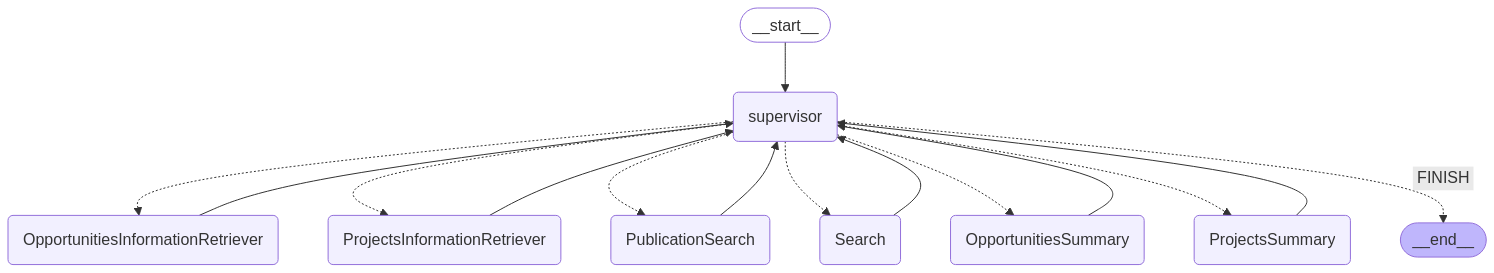

In [524]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Configure Team Members
team_members doesn't get implicitly passed to the chat prompt template, so this was my workaround.

In [564]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(research_graph.nodes),
    }
    return results

research_chain = enter_chain | chain

### Test Chain

In [565]:
for s in research_chain.stream(
    "generate a budget using the study complexity for funding opportunity PA-25-147", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'OpportunitiesInformationRetriever'}}
---
{'OpportunitiesInformationRetriever': {'messages': [HumanMessage(content='**Opportunity ID:** PA-25-147  \n**Opportunity Title:** NIDDK High Risk Multi-Center Clinical Study Cooperative Agreement (U01 Clinical Trial Required)  \n**Award Amount:** Application budgets are not limited but need to reflect the actual needs of the proposed project.  \n**Award Project Period:** The maximum project period is 5 years.  \n**Link to Announcement:** [PA-25-147 Announcement](https://grants.nih.gov/grants/guide/pa-files/PA-25-147.html)  \n\n### Project Complexity\n1. **Regulatory: Medium**\n   - Involves multiple regulatory requirements due to the multi-center aspect and the necessity for compliance with clinical trial regulations.\n\n2. **Data Collection and Management: High**\n   - Requires extensive and complex data collection across multiple clinical centers. Collecting various data elements involving a larger volume of subjects i

### Budget Analysis State

In [423]:
class BudgetTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Create Budget Team Tools

In [424]:
from langchain.tools import tool
from typing import Annotated

@tool
def do_nothing(
    input_text: Annotated[str, "Any input text."]
) -> Annotated[str, "A placeholder response indicating the tool does nothing."]:
    """
    A LangChain tool that does nothing and returns a generic response.
    Useful as a placeholder for debugging or tool testing.
    """
    return "This tool does nothing. You provided: " + input_text

In [590]:
personnel_effort_prompt = '''
You are an expert at calculating NIH personnel budgets. You use the provided study complexity and project duration to estimate 
the effort allocation percentage per year for different roles on the project team. Those roles include:

Key Personnel:
- DCC Principal Investigator (Required): Min 15% per year

Other Personnel:
- DCC Co-Principal Investigator (Optional): Min 15%
- Clinical Data Manager(s) (1 Required): Min 60%
- Statistician(s) (1 Required): Min 50%
- Clinical Project Manager (Required): Min 75%
- Business Project Manager (Required): Min 25% at start and then phase out
- Software Engineering (Optional): Depends on software development requirements and includes phase out
- IT Project Manager (Optional): Depeneds on software development requirements and includes phase out
- IT Operations (Required): Min 0%
- Ops Leader (Required): Min 10%
- Administrative Program Coordinator (Required): Min 10%
- Regulatory and Quality Assurance Manager (Optional): Min 5%
- Finance (Required): Min 5%
- Medical Monitor (Optional): Only if a medical monitor is required
- Business Intelligence (Optional): Depends on reporting requirements and includes phase out
- Biometrics Management (Required): Min 5%
- Clinical Project Manager Management (Required): Min 5%
- IT Management (Required): Depends on software development requirements

Calculate person months in addition to effort allocations by multiplying the effort allocation % by the total number of months.
Display the effort allocation % and calculated person months in a table with the roles listed in rows and the study years listed in columns.

Your work is complete after this table is created.
'''

personnel_effort_agent = create_agent(
    large_llm,
    [do_nothing],
    personnel_effort_prompt,
)
personnel_effort_node = functools.partial(
    agent_node, agent=personnel_effort_agent, name="PersonnelEffort"
)

personnel_justifications_prompt = '''
You are an expert at calculating NIH personnel budgets. You use the provided study complexity and project duration to estimate 
the effort allocation percentage per year for different roles on the project team. Those roles include:

Key Personnel:
- DCC Principal Investigator (Required): Min 15% per year

Other Personnel:
- DCC Co-Principal Investigator (Optional): Min 15%
- Clinical Data Manager(s) (1 Required): Min 60%
- Statistician(s) (1 Required): Min 50%
- Clinical Project Manager (Required): Min 75%
- Business Project Manager (Required): Min 25% at start and then phase out
- Software Engineering (Optional): Depends on software development requirements and includes phase out
- IT Project Manager (Optional): Depeneds on software development requirements and includes phase out
- IT Operations (Required): Min 0%
- Ops Leader (Required): Min 10%
- Administrative Program Coordinator (Required): Min 10%
- Regulatory and Quality Assurance Manager (Optional): Min 5%
- Finance (Required): Min 5%
- Medical Monitor (Optional): Only if a medical monitor is required
- Business Intelligence (Optional): Depends on reporting requirements and includes phase out
- Biometrics Management (Required): Min 5%
- Clinical Project Manager Management (Required): Min 5%
- IT Management (Required): Depends on software development requirements

Calculate person months in addition to effort allocations by multiplying the effort allocation % by the total number of months.
Display the effort allocation % and calculated person months in a table with the roles listed in rows and the study years listed in columns.

Your work is complete after this table is created.
'''

personnel_justifications_agent = create_agent(
    large_llm,
    [do_nothing],
    personnel_justifications_prompt,
)
personnel_justifications_node = functools.partial(
    agent_node, agent=personnel_justifications_agent, name="PersonnelJustifications"
)

nonpersonnel_costs_prompt = '''
You are an expert at calculating NIH personnel budgets. You use the provided study complexity and project duration to estimate 
the effort allocation percentage per year for different roles on the project team. Those roles include:

Key Personnel:
- DCC Principal Investigator (Required): Min 15% per year

Other Personnel:
- DCC Co-Principal Investigator (Optional): Min 15%
- Clinical Data Manager(s) (1 Required): Min 60%
- Statistician(s) (1 Required): Min 50%
- Clinical Project Manager (Required): Min 75%
- Business Project Manager (Required): Min 25% at start and then phase out
- Software Engineering (Optional): Depends on software development requirements and includes phase out
- IT Project Manager (Optional): Depeneds on software development requirements and includes phase out
- IT Operations (Required): Min 0%
- Ops Leader (Required): Min 10%
- Administrative Program Coordinator (Required): Min 10%
- Regulatory and Quality Assurance Manager (Optional): Min 5%
- Finance (Required): Min 5%
- Medical Monitor (Optional): Only if a medical monitor is required
- Business Intelligence (Optional): Depends on reporting requirements and includes phase out
- Biometrics Management (Required): Min 5%
- Clinical Project Manager Management (Required): Min 5%
- IT Management (Required): Depends on software development requirements

Calculate person months in addition to effort allocations by multiplying the effort allocation % by the total number of months.
Display the effort allocation % and calculated person months in a table with the roles listed in rows and the study years listed in columns.

Your work is complete after this table is created.
'''

nonpersonnel_costs_agent = create_agent(
    large_llm,
    [do_nothing],
    nonpersonnel_costs_prompt,
)
nonpersonnel_costs_node = functools.partial(
    agent_node, agent=nonpersonnel_costs_agent, name="NonPersonnelCosts"
)

nonpersonnel_justification_prompt = '''
You are an expert at calculating NIH personnel budgets. You use the provided study complexity and project duration to estimate 
the effort allocation percentage per year for different roles on the project team. Those roles include:

Key Personnel:
- DCC Principal Investigator (Required): Min 15% per year

Other Personnel:
- DCC Co-Principal Investigator (Optional): Min 15%
- Clinical Data Manager(s) (1 Required): Min 60%
- Statistician(s) (1 Required): Min 50%
- Clinical Project Manager (Required): Min 75%
- Business Project Manager (Required): Min 25% at start and then phase out
- Software Engineering (Optional): Depends on software development requirements and includes phase out
- IT Project Manager (Optional): Depeneds on software development requirements and includes phase out
- IT Operations (Required): Min 0%
- Ops Leader (Required): Min 10%
- Administrative Program Coordinator (Required): Min 10%
- Regulatory and Quality Assurance Manager (Optional): Min 5%
- Finance (Required): Min 5%
- Medical Monitor (Optional): Only if a medical monitor is required
- Business Intelligence (Optional): Depends on reporting requirements and includes phase out
- Biometrics Management (Required): Min 5%
- Clinical Project Manager Management (Required): Min 5%
- IT Management (Required): Depends on software development requirements

Calculate person months in addition to effort allocations by multiplying the effort allocation % by the total number of months.
Display the effort allocation % and calculated person months in a table with the roles listed in rows and the study years listed in columns.

Your work is complete after this table is created.
'''

nonpersonnel_justification_agent = create_agent(
    large_llm,
    [do_nothing],
    nonpersonnel_justification_prompt,
)
nonpersonnel_justification_node = functools.partial(
    agent_node, agent=nonpersonnel_justification_agent, name="NonPersonnelJustification"
)

budget_analysis_supervisor_prompt = '''
You are a supervisor tasked with managing a conversation between the following workers: PersonnelEffort. 
Given the user request, respond with the worker to act next. 
Allow each worker to complete only one draft before completing their assignment.
When your team's work is complete, you must respond with FINISH.
'''

budget_analysis_supervisor = create_team_supervisor(
    large_llm,
    budget_analysis_supervisor_prompt,
    ["PersonnelEffort"],
)

In [582]:
budget_analysis_graph = StateGraph(BudgetTeamState)
budget_analysis_graph.add_node("PersonnelEffort", personnel_effort_node)
budget_analysis_graph.add_node("supervisor", budget_analysis_supervisor)

budget_analysis_graph.add_edge("PersonnelEffort", "supervisor")

budget_analysis_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PersonnelEffort": "PersonnelEffort",
        "FINISH": END,
    },
)

budget_analysis_graph.set_entry_point("supervisor")
chain = budget_analysis_graph.compile()

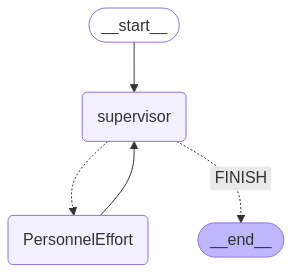

In [495]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [583]:
def enter_budget_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

budget_analysis_chain = (
    functools.partial(enter_budget_chain, members=budget_analysis_graph.nodes)
    | budget_analysis_graph.compile()
)

In [429]:
for s in budget_analysis_chain.stream(
    "Create a budget for a high-risk study requiring the detailed form",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'PersonnelEffort'}}
---
{'PersonnelEffort': {'messages': [HumanMessage(content='To create the budget for a high-risk study, we first need to determine the project duration. Could you please provide the duration of the study in years?', additional_kwargs={}, response_metadata={}, name='PersonnelEffort')]}}
---
{'supervisor': {'next': 'PersonnelEffort'}}
---
{'PersonnelEffort': {'messages': [HumanMessage(content='To proceed with the calculations for the personnel budget, I need details on the project duration in years, the roles required, and any specific percentage efforts beyond the minimum stated. Please provide this information or confirm if I should use the stated minimums for the calculations.', additional_kwargs={}, response_metadata={}, name='PersonnelEffort')]}}
---
{'supervisor': {'next': 'PersonnelEffort'}}
---
{'PersonnelEffort': {'messages': [HumanMessage(content="To proceed with the personnel budget calculations, please confirm the duration of the st

KeyboardInterrupt: 

### Document Writing State

In [570]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Load Budget Guidelines Data

In [431]:
from langchain_community.document_loaders import WebBaseLoader

# Define the webpage URL
budget_guidelines_url = "https://grants.nih.gov/grants-process/write-application/advice-on-application-sections/develop-your-budget"

# Load the webpage
budget_guidelines_loader = WebBaseLoader(budget_guidelines_url)
budget_guidelines = budget_guidelines_loader.load()

### Populate Vector Stores

In [432]:
from langchain_community.vectorstores import Qdrant

budget_guidelines_vectorstore = Qdrant.from_documents(
    budget_guidelines,
    embedding_model,
    location=":memory:",
    collection_name="budget_guidelines",
)

### Create Retrievers

In [433]:
budget_guidelines_retriever = budget_guidelines_vectorstore.as_retriever()

### Initialize LLMs

In [396]:
budget_llm = ChatOpenAI(model="gpt-4o-mini", tags=["budget_llm"])

### Create Prompt Templates

In [397]:
budget_guidelines_prompt_template = """\
Use only the provided budget form and additional budget guidelines, provide specific instructions for creating the NIH budget.

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

budget_guidelines_prompt = ChatPromptTemplate.from_template(budget_guidelines_prompt_template)

### Create RAG Chains

In [398]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

budget_guidelines_chain = (
    {"context": itemgetter("question") | budget_guidelines_retriever, "question": itemgetter("question") }
    | budget_guidelines_prompt | budget_llm | StrOutputParser()
)

### Test RAG Chains

In [332]:
response = budget_guidelines_chain.invoke({"question" : "what are my budget guidelines for the detailed form"})
pprint.pprint(response)

('To create the NIH budget using the detailed budget form, follow these '
 'specific guidelines:\n'
 '\n'
 '1. **Personnel (Sections A & B)**:\n'
 '   - List all personnel from your organization that will dedicate effort to '
 'the project, including their base salary and effort (in person months).\n'
 '   - Ensure effort is reported in person months and in compliance with NIH '
 'salary caps, which can be found on the Salary Cap Summary.\n'
 '   - Include Senior/Key Personnel and justify their roles. "Other '
 'Significant Contributors" with negligible effort should not be included.\n'
 '   - For postdoctoral associates, specify their involvement depending on '
 'their role.\n'
 '   - Costs for secretarial/clerical staff should typically be treated as F&A '
 'costs, unless specific to the project.\n'
 '\n'
 '2. **Equipment (Section C)**:\n'
 '   - Define equipment as items costing $5,000 or more with a service life '
 'exceeding one year.\n'
 '   - Justify why new equipment is necessa

### Create Document Tools

In [399]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('data/Documents', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('data/Documents', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

@tool
def retrieve_budget_guidelines(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve budget guidelines"""
  return budget_guidelines_chain.invoke({"question" : query})

In [400]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [571]:
budget_guidelines_prompt = '''
You are an expert at preparing budget guidelines. 
Using only the provided NIH budget form and retrieved budget guidelines,
you create a template for the rest of your teammates to contribute to.
'''

budget_guidelines_agent = create_agent(
    small_llm,
    [retrieve_budget_guidelines],
    budget_guidelines_prompt,
)
budget_guidelines_node = functools.partial(
    agent_node, agent=budget_guidelines_agent, name="BudgetGuidelines"
)

budget_writer_prompt = '''
You are an expert writing documents. 
You may only use the information provided by the budget analysis team to generate your document. 
You must include all of the budget team's analysis in the document and not make any changes."
Below are files currently in your directory:\n{current_files}
'''

budget_writer_agent = create_agent(
    large_llm,
    [write_document, edit_document, read_document],
    (""),
)
context_aware_budget_writer_agent = prelude | budget_writer_agent
budget_writing_node = functools.partial(
    agent_node, agent=context_aware_budget_writer_agent, name="BudgetWrite"
)

doc_writing_supervisor_prompt = '''
You are a supervisor tasked with managing a conversation between the following workers: {team_members}. 
You should always verify the technical contents after any edits are made. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status.  
When each team is finished, you must respond with FINISH.
'''

doc_writing_supervisor = create_team_supervisor(
    large_llm,
    doc_writing_supervisor_prompt,
    ["BudgetWriter"],
)

### Graph Configuration

In [572]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("BudgetWriter", budget_writing_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("BudgetWriter", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "BudgetWriter": "BudgetWriter",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()

### Display Graph

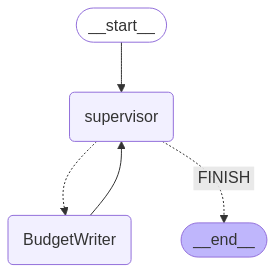

In [573]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [574]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

### Test Chain

In [66]:
for s in authoring_chain.stream(
    "Create a budget for funding opportunity PA-25-147. ",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'BudgetWriter'}}
---
{'BudgetWriter': {'messages': [HumanMessage(content='As a Supervisor, I would need assistance from the BudgetWriter team member to create the budget for funding opportunity PA-25-147. I cannot individually create the budget document but my role involves overseeing the process. I will now direct the task to the BudgetWriter to create the necessary budget document.', additional_kwargs={}, response_metadata={}, name='BudgetWrite')]}}
---
{'supervisor': {'next': 'BudgetWriter'}}
---
{'BudgetWriter': {'messages': [HumanMessage(content="Since the task requires specialized input for budget creation, it will be handled by a BudgetWriter. I'll make sure the process is overseen and completed as per the requirements for funding opportunity PA-25-147.", additional_kwargs={}, response_metadata={}, name='BudgetWrite')]}}
---
{'supervisor': {'next': 'BudgetWriter'}}
---
{'BudgetWriter': {'messages': [HumanMessage(content="As the Supervisor, I will ensure t

KeyboardInterrupt: 

### One Agent to Rule Them All

In [584]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

super_supervisor_prompt = '''
You are a supervisor tasked with managing a conversation between the following teams: {team_members}. 
Given the following user request, respond with the team to act next. 
Each team will perform a task and respond with their results and status.  
When all teams are finished, you must respond with FINISH.
'''

supervisor_node = create_team_supervisor(
    xlarge_llm,
    super_supervisor_prompt,
    ["Research team", "Budget Analysis team", "Documents team"],
)

In [585]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

In [586]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Budget Analysis team", get_last_message | budget_analysis_chain | join_graph)
super_graph.add_node(
    "Documents team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

In [587]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Budget Analysis team", "supervisor")
super_graph.add_edge("Documents team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Documents team": "Documents team",
        "Budget Analysis team": "Budget Analysis team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

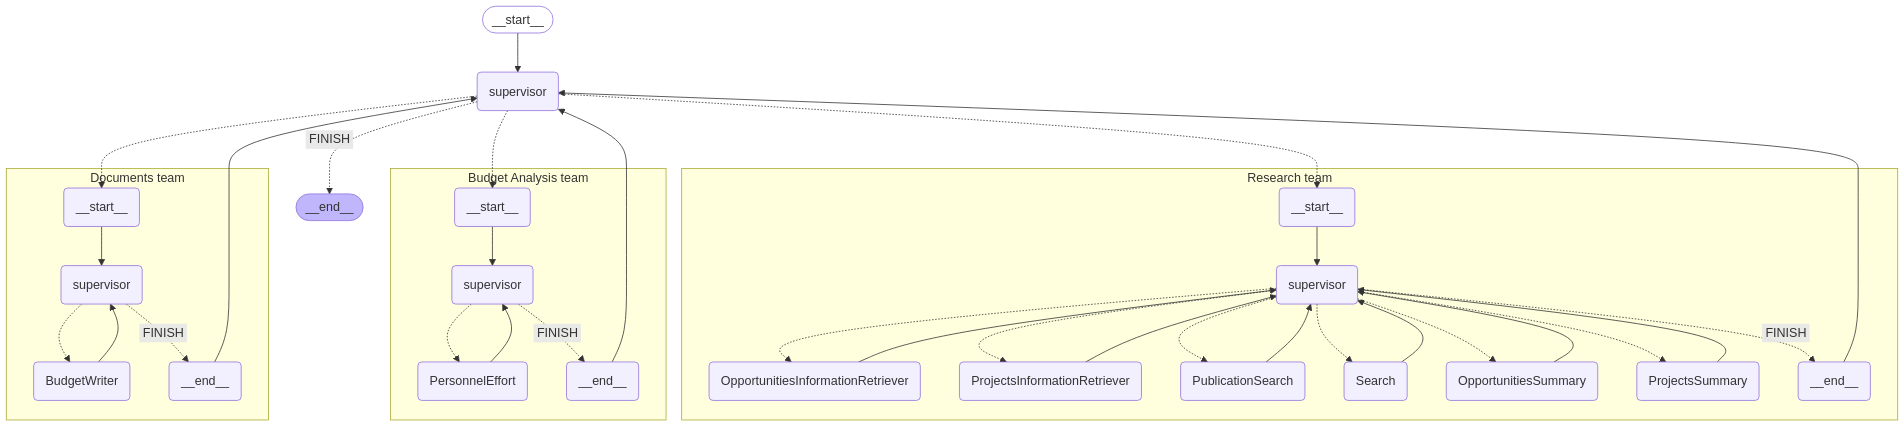

In [579]:
from IPython.display import Image, display

try:
    display(Image(super_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [588]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

#content = "Generate a budget for opportunity PA-25-147. Use the research team to collect information about opportunity PA-25-147. Use the budget analysis team to generate a budget from the study complexity provided by the research team. And then use the documents team to write the budget team's output to a new file."

for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Determine the study complexity for funding opportunity PA-25-147. Then have the budget analysis team estimate effort allocation and person months. Finally have the documents team save the budget analysis team's results to a new file."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='The study complexity for funding opportunity PA-25-147, NIDDK High Risk Multi-Center Clinical Study Cooperative Agreement (U01 Clinical Trial Required), is rated as high across several dimensions:\n\n1) **Regulatory: High** - Compliance with various regulations including IRB approvals and FDA regulations is required.\n2) **Data Collection and Management: High** - Involves managing sophisticated data from multiple sites.\n3) **Statistical Analysis and Manuscript Development: High** - Requires advanced statistical methodologies for analyzing site-variable data.\n4) **Information Technology: High** - Significant IT infrastructure and software are needed.\n5) **Operational: High** - Extensive planning and communication across diverse sites.\n6) **Financial: High** - Complex financial management across multiple sites and funding approvals.\n\nThis funding opportunity has high complexity in al